<a href="https://colab.research.google.com/github/superahxd/_project/blob/main/sec4/sec4_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

프로젝트

- kaggle 트위터 데이터셋으로 lstm 학습
- DokeV 감정분석해보기

column 설명
```
target: the polarity of the tweet (0 = negative, 2 = neutral, 4 = positive)
ids: The id of the tweet ( 2087)
date: the date of the tweet (Sat May 16 23:58:44 UTC 2009)
flag: The query (lyx). If there is no query, then this value is NO_QUERY.
user: the user that tweeted (robotickilldozr)
text: the text of the tweet (Lyx is cool)
```

In [2]:
!pip install keras --upgrade
!pip install pandas --upgrade
!pip install nltk

In [15]:
# kaggle tweet set 불러오기

!pip install kaggle
#from google.colab import files
#files.upload()

In [16]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
# Permission Warning이 발생하지 않도록 해줍니다.
!chmod 600 ~/.kaggle/kaggle.json

In [17]:
! kaggle datasets download -d kazanova/sentiment140

sentiment140.zip: Skipping, found more recently modified local copy (use --force to force download)


In [18]:
! unzip -qq "/content/sentiment140.zip"

replace training.1600000.processed.noemoticon.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n


In [19]:
# utilities
import re
import pickle
import numpy as np
import pandas as pd

# plotting
import seaborn as sns
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# nltk
from nltk.stem import WordNetLemmatizer

# sklearn
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report

In [20]:
# Importing the dataset
DATASET_COLUMNS  = ["sentiment", "ids", "date", "flag", "user", "text"]
DATASET_ENCODING = "ISO-8859-1"
dataset = pd.read_csv('/content/training.1600000.processed.noemoticon.csv',
                      encoding=DATASET_ENCODING , names=DATASET_COLUMNS)

# Removing the unnecessary columns.
dataset = dataset[['sentiment','text']]

print(dataset)

         sentiment                                               text
0                0  @switchfoot http://twitpic.com/2y1zl - Awww, t...
1                0  is upset that he can't update his Facebook by ...
2                0  @Kenichan I dived many times for the ball. Man...
3                0    my whole body feels itchy and like its on fire 
4                0  @nationwideclass no, it's not behaving at all....
...            ...                                                ...
1599995          4  Just woke up. Having no school is the best fee...
1599996          4  TheWDB.com - Very cool to hear old Walt interv...
1599997          4  Are you ready for your MoJo Makeover? Ask me f...
1599998          4  Happy 38th Birthday to my boo of alll time!!! ...
1599999          4  happy #charitytuesday @theNSPCC @SparksCharity...

[1600000 rows x 2 columns]


In [21]:
dataset['sentiment'].value_counts()

0    800000
4    800000
Name: sentiment, dtype: int64

In [22]:
# 4를 1로 바꾼다. 1=positive , 0=negative
dataset['sentiment'] = dataset['sentiment'].replace(4,1)

# Storing data in lists.
text, sentiment = list(dataset['text']), list(dataset['sentiment'])

print(dataset)

         sentiment                                               text
0                0  @switchfoot http://twitpic.com/2y1zl - Awww, t...
1                0  is upset that he can't update his Facebook by ...
2                0  @Kenichan I dived many times for the ball. Man...
3                0    my whole body feels itchy and like its on fire 
4                0  @nationwideclass no, it's not behaving at all....
...            ...                                                ...
1599995          1  Just woke up. Having no school is the best fee...
1599996          1  TheWDB.com - Very cool to hear old Walt interv...
1599997          1  Are you ready for your MoJo Makeover? Ask me f...
1599998          1  Happy 38th Birthday to my boo of alll time!!! ...
1599999          1  happy #charitytuesday @theNSPCC @SparksCharity...

[1600000 rows x 2 columns]


In [23]:
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
import nltk

nltk.download('stopwords')

stopwordlist = stopwords.words('english')
stemmer = SnowballStemmer('english')
emojis = {':)': 'smile', ':-)': 'smile', ';d': 'wink', ':-E': 'vampire', ':(': 'sad', 
          ':-(': 'sad', ':-<': 'sad', ':P': 'raspberry', ':O': 'surprised',
          ':-@': 'shocked', ':@': 'shocked',':-$': 'confused', ':\\': 'annoyed', 
          ':#': 'mute', ':X': 'mute', ':^)': 'smile', ':-&': 'confused', '$_$': 'greedy',
          '@@': 'eyeroll', ':-!': 'confused', ':-D': 'smile', ':-0': 'yell', 'O.o': 'confused',
          '<(-_-)>': 'robot', 'd[-_-]b': 'dj', ":'-)": 'sadsmile', ';)': 'wink', 
          ';-)': 'wink', 'O:-)': 'angel','O*-)': 'angel','(:-D': 'gossip', '=^.^=': 'cat'}

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [24]:
def preprocess(textdata):
    processedText = []
    
    # Create Lemmatizer and Stemmer. 표제어 추출하기
    wordLemm = WordNetLemmatizer()
    
    # Defining regex patterns. 정규식 패턴
    urlPattern        = r"((http://)[^ ]*|(https://)[^ ]*|( www\.)[^ ]*)" 
    userPattern       = '@[^\s]+' #@으로 시작하는 유저 아이디 제거
    alphaPattern      = "[^a-zA-Z]" #영어 대소문자 외 제거
    sequencePattern   = r"(.)\1\1+" #중복글자 제거
    seqReplacePattern = r"\1\1" #중복글자제거
    
    for tweet in textdata:
        tweet = tweet.lower() #소문자화
        #http, www, https로 시작하는 url 제거
        tweet = re.sub(urlPattern,' URL',tweet)
        # 이모지 대체
        for emoji in emojis.keys():
            tweet = tweet.replace(emoji, "EMOJI" + emojis[emoji])        
        # 유저 아이디 대체
        tweet = re.sub(userPattern,' USER', tweet)        
        # 알파벳 아닌 것 모두 대체
        tweet = re.sub(alphaPattern, " ", tweet)
        # 3개 이상의 연속된 문자를 2자로 대체
        tweet = re.sub(sequencePattern, seqReplacePattern, tweet)

        tweetwords = ''
        for word in tweet.split():
            # stopword에 들어있는지 확인
            # stopword에 없으면:
            if len(word)>1:
                # Lemmatizing 실행
                word = wordLemm.lemmatize(word)
                tweetwords += (word+' ')
            
        processedText.append(tweetwords)
        
    return processedText

In [25]:
import time

nltk.download('wordnet')

t = time.time()
processedtext = preprocess(text)
print(f'Text Preprocessing complete.')
print(f'Time Taken: {round(time.time()-t)} seconds')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
Text Preprocessing complete.
Time Taken: 113 seconds


In [26]:
df = pd.DataFrame(processedtext)

##Tokenization

In [27]:
TRAIN_SIZE = 0.8
MAX_NB_WORDS = 100000
MAX_SEQUENCE_LENGTH = 30

In [28]:
X_train, X_test, y_train, y_test = train_test_split(processedtext, sentiment, test_size=1-TRAIN_SIZE, random_state=42)
print("TRAIN size:", len(X_train))
print("TEST size:", len(X_test))

TRAIN size: 1280000
TEST size: 320000


In [29]:
from keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

word_index = tokenizer.word_index
vocab_size = len(tokenizer.word_index) + 1
print("Vocabulary Size :", vocab_size)

Vocabulary Size : 205203


In [30]:
from keras.preprocessing.sequence import pad_sequences

x_train = pad_sequences(tokenizer.texts_to_sequences(X_train),
                        maxlen = MAX_SEQUENCE_LENGTH)
x_test = pad_sequences(tokenizer.texts_to_sequences(X_test),
                       maxlen = MAX_SEQUENCE_LENGTH)

print("Training X Shape:",x_train.shape)
print("Testing X Shape:",x_test.shape)

Training X Shape: (1280000, 30)
Testing X Shape: (320000, 30)


In [31]:
#y_train = pd.DataFrame(y_train)
#labels = y_train.value_counts().tolist()

### Label Encoding

In [32]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
encoder.fit(y_train)

y_train = encoder.transform(y_train)
y_test = encoder.transform(y_test)

y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

y_train shape: (1280000, 1)
y_test shape: (320000, 1)


## Word embedding

</br>
미리 학습된 임베딩 사용 
</br>
GloVe Embedding from Stanford AI

In [33]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip glove.6B.zip

--2021-09-03 06:15:13--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2021-09-03 06:15:13--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2021-09-03 06:15:14--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip.1’

glove

In [34]:
GLOVE_EMB = 'glove.6B.300d.txt'
EMBEDDING_DIM = 300
LR = 1e-3
BATCH_SIZE = 1024
EPOCHS = 10
MODEL_PATH = '.../output/kaggle/working/best_model.hdf5'

In [35]:
embeddings_index = {}

f = open(GLOVE_EMB)
for line in f:
  values = line.split()
  word = value = values[0]
  coefs = np.asarray(values[1:], dtype='float32')
  embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' %len(embeddings_index))

Found 400000 word vectors.


In [36]:
embedding_matrix = np.zeros((vocab_size, EMBEDDING_DIM))
for word, i in word_index.items():
  embedding_vector = embeddings_index.get(word)
  if embedding_vector is not None:
    embedding_matrix[i] = embedding_vector

In [37]:
import tensorflow as tf

embedding_layer = tf.keras.layers.Embedding(vocab_size,
                                          EMBEDDING_DIM,
                                          weights=[embedding_matrix],
                                          input_length=MAX_SEQUENCE_LENGTH,
                                          trainable=False)

BASELINE

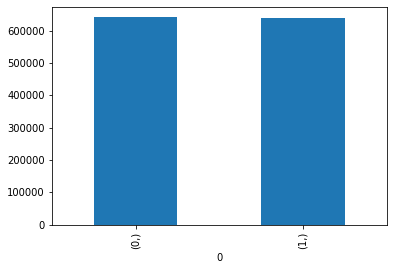

In [40]:
pd.DataFrame(y_train).value_counts().plot(kind = 'bar')

# Model Training - LSTM

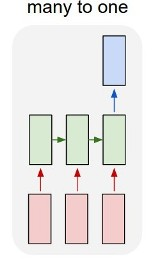

1) Embedding Layer - Generates Embedding Vector for each input sequence.

2) SpatialDropout1D layer - dropout과 동일한 기능이지만 개별 요소 대신 1차원 피쳐맵을 삭제한다. early convolution layer에서 피쳐 맵 내의 인접 프레임이 강하게 연결되어 있는 경우 기존의 dropout은 정규화 못함. 학습속도만 저하일으킴. spatial dropout이 피쳐 맵 간 독립성을 높이는데 도움되므로 대신 사용해야함 

3) Conv1D Layer - 더 작은 피쳐 벡터로 만들기 위해 사용

4) LSTM - Long Short Term Memory, its a variant of RNN which has memory state cell to learn the context of words which are at further along the text to carry contextual meaning rather than just neighbouring words as in case of RNN.

4-1) Bidirectional layer - 입력 내용이 과거에서 미래, 미래에서 과거 양방향으로 실행되어 정보를 두 시점의 정보를 보존할 수 있다. 

5) Dense - Fully Connected Layers for classification

In [42]:
from tensorflow.keras.layers import Conv1D, Bidirectional, LSTM, Dense, Input, Dropout
from tensorflow.keras.layers import SpatialDropout1D
from tensorflow.keras.callbacks import ModelCheckpoint

In [43]:
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedding_sequences = embedding_layer(sequence_input)
x = SpatialDropout1D(0.2)(embedding_sequences)
x = Conv1D(64, 5, activation='relu')(x)
x = Bidirectional(LSTM(64, dropout=0.2, recurrent_dropout=0.2))(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(512, activation='relu')(x)
outputs = Dense(1, activation='sigmoid')(x)
model = tf.keras.Model(sequence_input, outputs)

In [44]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 30)]              0         
_________________________________________________________________
embedding (Embedding)        (None, 30, 300)           61560900  
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 30, 300)           0         
_________________________________________________________________
conv1d (Conv1D)              (None, 26, 64)            96064     
_________________________________________________________________
bidirectional (Bidirectional (None, 128)               66048     
_________________________________________________________________
dense (Dense)                (None, 512)               66048     
_________________________________________________________________
dropout (Dropout)            (None, 512)               0     

In [45]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau

model.compile(optimizer=Adam(learning_rate=LR), loss='binary_crossentropy',
              metrics=['accuracy'])

#콜백, 모델의 개선이 없을 경우, Learning Rate를 조절해 모델의 개선을 유도
ReduceLROnPlateau = ReduceLROnPlateau(factor=0.1,
                                     min_lr = 0.01,
                                     monitor = 'val_loss',
                                     verbose = 1)

In [46]:
history = model.fit(x_train, y_train, batch_size=BATCH_SIZE, epochs=EPOCHS,
                    validation_data=(x_test, y_test), callbacks=[ReduceLROnPlateau])

Epoch 1/10
1250/1250 [==============================] - 168s 107ms/step - loss: 0.4803 - accuracy: 0.7674 - val_loss: 0.4296 - val_accuracy: 0.8000
Epoch 2/10
1250/1250 [==============================] - 134s 107ms/step - loss: 0.4382 - accuracy: 0.7951 - val_loss: 0.4162 - val_accuracy: 0.8076
Epoch 3/10
1250/1250 [==============================] - 134s 107ms/step - loss: 0.4252 - accuracy: 0.8029 - val_loss: 0.4082 - val_accuracy: 0.8123
Epoch 4/10
1250/1250 [==============================] - 133s 107ms/step - loss: 0.4170 - accuracy: 0.8077 - val_loss: 0.4030 - val_accuracy: 0.8157
Epoch 5/10
1250/1250 [==============================] - 132s 106ms/step - loss: 0.4111 - accuracy: 0.8109 - val_loss: 0.4015 - val_accuracy: 0.8164
Epoch 6/10
1250/1250 [==============================] - 132s 106ms/step - loss: 0.4069 - accuracy: 0.8135 - val_loss: 0.4010 - val_accuracy: 0.8176
Epoch 7/10
1250/1250 [==============================] - 133s 106ms/step - loss: 0.4030 - accuracy: 0.8152 - val_

####evaluate

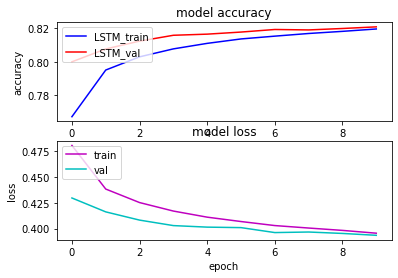

In [47]:
s, (at, al) = plt.subplots(2,1)
at.plot(history.history['accuracy'], c= 'b')
at.plot(history.history['val_accuracy'], c='r')
at.set_title('model accuracy')
at.set_ylabel('accuracy')
at.set_xlabel('epoch')
at.legend(['LSTM_train', 'LSTM_val'], loc='upper left')

al.plot(history.history['loss'], c='m')
al.plot(history.history['val_loss'], c='c')
al.set_title('model loss')
al.set_ylabel('loss')
al.set_xlabel('epoch')
al.legend(['train', 'val'], loc = 'upper left')

In [48]:
def decode_sentiment(score):
    return "Positive" if score>0.5 else "Negative"


scores = model.predict(x_test, verbose=1, batch_size=10000)
y_pred_1d = [decode_sentiment(score) for score in scores]

score = model.evaluate(x_test, y_test, batch_size=BATCH_SIZE)
print()
print("ACCURACY:",score[1])
print("LOSS:",score[0])

313/313 [==============================] - 5s 17ms/step - loss: 0.3936 - accuracy: 0.8207

ACCURACY: 0.8207218647003174
LOSS: 0.3935725688934326


### confusion matrix

In [49]:
import itertools
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=20)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, fontsize=13)
    plt.yticks(tick_marks, classes, fontsize=13)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label', fontsize=17)
    plt.xlabel('Predicted label', fontsize=17)

In [88]:
def sentiment_predict(new_sentence):
  pad_new = pad_sequences(tokenizer.texts_to_sequences(new_sentence),
                        maxlen = MAX_SEQUENCE_LENGTH)
  score = float(model.predict(pad_new)) # 예측
  if(score > 0.5):
    print("{:.2f}% 확률로 긍정 리뷰입니다.\n".format(score * 100))
  else:
    print("{:.2f}% 확률로 부정 리뷰입니다.\n".format((1 - score) * 100))

In [54]:
from google.colab import files
uploaded = files.upload() # 파일 업로드 기능 실행

Saving last.csv to last.csv


In [78]:
temp_str = pd.read_csv('last.csv', index_col=0)
temp_str = pd.DataFrame(temp_str)

In [94]:
temp_str.shape

(6208, 1)

In [90]:
sentiment_predict(temp_str)

54.82% 확률로 긍정 리뷰입니다.

